In [ ]:
!pip install ultralytics opencv-python torch torchvision torchaudio numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.2 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
from ultralytics import YOLO
# Load model
model_path = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
model = YOLO(model_path)
# Detection parameters
conf_thres = 0.5
iou_thres = 0.45
imgsz = 640
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cpu


In [ ]:
import torch
print(torch.cuda.is_available())


False


In [ ]:
import glob
import os

# Base dataset path
base_dir = "/content/drive/MyDrive/Project/Dataset"

# Search for common video formats recursively
video_extensions = ["*.mp4", "*.avi", "*.mov", "*.mkv"]
video_files = []
for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(base_dir, "**", ext), recursive=True))

# Display found videos
print("Found video files:")
for v in video_files:
    print(v)

print(f"\nTotal videos found: {len(video_files)}")


🎥 Found video files:
/content/drive/MyDrive/Project/Dataset/source_files/source_files/hardhat.mp4
/content/drive/MyDrive/Project/Dataset/source_files/source_files/JapanPPE.mp4
/content/drive/MyDrive/Project/Dataset/source_files/source_files/indianworkers.mp4
/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/videos/hardhat.mp4
/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/videos/indianworkers.mp4
/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs/detections_videos/hardhat.avi
/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs/detections_videos/indianworkers.avi
/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs/detections_videos2/indianworkers.avi

✅ Total videos found: 8


In [ ]:
import cv2

video_path = "/content/drive/MyDrive/Project/Dataset/source_files/source_files/JapanPPE.mp4"
output_path = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs"

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 20.0,
                      (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(source=frame, conf=conf_thres, iou=iou_thres, imgsz=imgsz, device=device, verbose=False)
    annotated_frame = results[0].plot()
    out.write(annotated_frame)

cap.release()
out.release()

print(f"🎥 Detection video saved at: {output_path}")


🎥 Detection video saved at: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs


✅ Model loaded from: /content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt
🎥 Processing video: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/videos/indianworkers.mp4
Resolution: 1280x720, FPS: 29
Processed 50 frames...
Processed 100 frames...
Processed 150 frames...
Processed 200 frames...
Processed 250 frames...
Processed 300 frames...
Processed 350 frames...
Processed 400 frames...
Processed 450 frames...
Processed 500 frames...
Processed 550 frames...
Processed 600 frames...

✅ Annotated video saved: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs/annotated_output.mp4
📜 Violation log saved: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs/logs/violations_log.csv


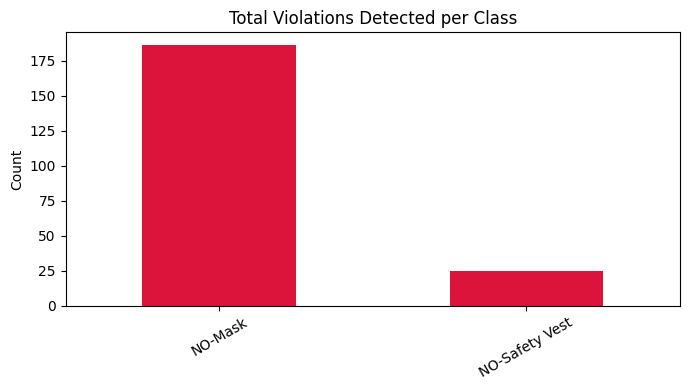

📊 Summary chart saved: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs/logs/violation_summary.png


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
from datetime import datetime
import matplotlib.pyplot as plt

# === CONFIG ===
VIDEO_PATH = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/videos/indianworkers.mp4"  # 👈 Change this
OUTPUT_DIR = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/outputs"

MODEL_PATH = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "logs"), exist_ok=True)

OUTPUT_VIDEO = os.path.join(OUTPUT_DIR, "annotated_output.mp4")
LOG_CSV = os.path.join(OUTPUT_DIR, "logs/violations_log.csv")

CONF_THRES = 0.4
IOU_THRES = 0.45
DEVICE = "cpu"  # or 'cuda' if GPU is available

# === MODEL LOAD ===
model = YOLO(MODEL_PATH)
print(f"✅ Model loaded from: {MODEL_PATH}")

# === COLOR CODING ===
VIOLATION_CLASSES = ["NO-Hardhat", "NO-Mask", "NO-Safety Vest"]
SAFE_COLOR = (0, 255, 0)   # Green
VIOL_COLOR = (255, 0, 0)   # Red

# === LOG INITIALIZATION ===
violations_list = []

# === UTILS ===
def draw_boxes(image, detections):
    draw = ImageDraw.Draw(image)
    for det in detections:
        label = det["label"]
        conf = det["conf"]
        box = det["box"]

        color = VIOL_COLOR if label in VIOLATION_CLASSES else SAFE_COLOR
        draw.rectangle(box, outline=color, width=3)
        draw.text((box[0]+5, box[1]-15), f"{label} {conf:.2f}", fill=color)
    return image


def log_violations(detections, timestamp):
    for det in detections:
        if det["label"] in VIOLATION_CLASSES:
            violations_list.append({
                "Timestamp": timestamp,
                "Violation": det["label"],
                "Confidence": round(det["conf"], 3)
            })


def results_to_list(result, class_names):
    """Convert YOLO result to a list of detections"""
    dets = []
    for box in result.boxes:
        cls_id = int(box.cls[0])
        dets.append({
            "label": class_names[cls_id],
            "conf": float(box.conf[0]),
            "box": [int(x) for x in box.xyxy[0].tolist()]
        })
    return dets


# === VIDEO PROCESSING ===
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"❌ Could not open video: {VIDEO_PATH}")

fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (w, h))

frame_count = 0

print(f"🎥 Processing video: {VIDEO_PATH}")
print(f"Resolution: {w}x{h}, FPS: {fps}")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    timestamp = datetime.now().strftime("%H:%M:%S")

    results = model.predict(frame, conf=CONF_THRES, iou=IOU_THRES, device=DEVICE, verbose=False)
    dets = results_to_list(results[0], model.names)

    # Log and draw
    log_violations(dets, timestamp)
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    annotated_pil = draw_boxes(frame_pil, dets)
    frame_bgr = cv2.cvtColor(np.array(annotated_pil), cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)

    if frame_count % 50 == 0:
        print(f"Processed {frame_count} frames...")

cap.release()
out.release()

print(f"\n✅ Annotated video saved: {OUTPUT_VIDEO}")

# === SAVE VIOLATION LOG ===
if violations_list:
    df = pd.DataFrame(violations_list)
    df.to_csv(LOG_CSV, index=False)
    print(f"📜 Violation log saved: {LOG_CSV}")
else:
    print("✅ No violations detected!")

# === SUMMARY BAR CHART ===
if len(violations_list) > 0:
    summary = pd.Series([v["Violation"] for v in violations_list]).value_counts()
    plt.figure(figsize=(7, 4))
    summary.plot(kind="bar", color="crimson")
    plt.title("Total Violations Detected per Class")
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout()

    summary_path = os.path.join(OUTPUT_DIR, "logs/violation_summary.png")
    plt.savefig(summary_path)
    plt.show()

    print(f"📊 Summary chart saved: {summary_path}")
else:
    print("No violations to summarize.")


In [ ]:
import os
import shutil
import glob

# Define paths
src_folder = "/content/drive/MyDrive/Project/Dataset/source_files/source_files"
demo_base = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo"

img_demo = os.path.join(demo_base, "images")
vid_demo = os.path.join(demo_base, "videos")

# Ensure folders exist
os.makedirs(img_demo, exist_ok=True)
os.makedirs(vid_demo, exist_ok=True)

# Copy all image files
image_files = glob.glob(f"{src_folder}/*.jpg") + glob.glob(f"{src_folder}/*.png")
for img in image_files:
    shutil.copy(img, img_demo)
    print(f"📸 Copied image: {os.path.basename(img)}")

# Copy all video files
video_files = glob.glob(f"{src_folder}/*.mp4")
for vid in video_files:
    shutil.copy(vid, vid_demo)
    print(f"Copied video: {os.path.basename(vid)}")

print("\nAll images and videos copied successfully!")
print("Images folder:", img_demo)
print("Videos folder:", vid_demo)


📸 Copied image: construction-safety.jpg
📸 Copied image: two-young-construction-workers-wearing-555864.jpg
📸 Copied image: schupan_japan1web.jpg
📸 Copied image: portrait-of-woman-with-mask-and-man-with-safety-glasses-on-a-construction-HX01FH.jpg
🎞️ Copied video: hardhat.mp4
🎞️ Copied video: JapanPPE.mp4
🎞️ Copied video: indianworkers.mp4

✅ All images and videos copied successfully!
📂 Images folder: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/images
📂 Videos folder: /content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/videos


In [ ]:
import cv2
import torch
import os
from ultralytics import YOLO
from datetime import datetime

# ==============================
# 🔧 CONFIGURATION
# ==============================
MODEL_PATH = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
VIDEO_PATH = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/visual_demo/videos/JapanPPE.mp4"
OUTPUT_DIR = "/content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CONF_THRES = 0.5
IOU_THRES = 0.45
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {DEVICE}")

# ==============================
# 🎯 LOAD MODEL
# ==============================
model = YOLO(MODEL_PATH)
model.to(DEVICE)
print("✅ Model loaded successfully!")

# ==============================
# ⚙️ RULE EVALUATION FUNCTION
# ==============================
def evaluate_rules_all_classes(detections):
    """
    Evaluate PPE compliance for all YOLO classes.
    Marks non-compliance when 'NO-' labels are detected or PPE is missing.
    """
    gear_present = {'Hardhat': False, 'Mask': False, 'Safety Vest': False}
    violations = []

    for det in detections:
        label = det['label']

        # --- Violations ---
        if label in ['NO-Hardhat', 'NO-Mask', 'NO-Safety Vest']:
            violations.append(label.replace('NO-', 'No '))

        # --- PPE present ---
        elif label in ['Hardhat', 'Mask', 'Safety Vest']:
            gear_present[label] = True

    # --- Check for missing PPE if not explicitly detected ---
    if not gear_present['Hardhat'] and all(v != 'No Hardhat' for v in violations):
        violations.append('No Hardhat (Missing)')
    if not gear_present['Safety Vest'] and all(v != 'No Safety Vest' for v in violations):
        violations.append('No Safety Vest (Missing)')
    if not gear_present['Mask'] and all(v != 'No Mask' for v in violations):
        violations.append('No Mask (Missing)')

    if len(violations) == 0:
        return {"status": "Compliant", "violations": [], "color": (0, 255, 0)}
    else:
        return {"status": "Violation", "violations": violations, "color": (0, 0, 255)}

# ==============================
# 🎥 VIDEO INFERENCE LOOP
# ==============================
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"❌ Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(3)), int(cap.get(4))

output_path = os.path.join(OUTPUT_DIR, "ppe_violation_output.mp4")
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

frame_id = 0
log_path = os.path.join(OUTPUT_DIR, "violation_log.txt")

print("🚀 Running inference... Press Ctrl+C to stop early.")

with open(log_path, "w") as log_file:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_id += 1

        results = model.predict(frame, conf=CONF_THRES, iou=IOU_THRES, imgsz=640, device=DEVICE, verbose=False)

        detections = []
        for box in results[0].boxes:
            label = model.names[int(box.cls[0])]
            conf = float(box.conf[0])
            detections.append({'label': label, 'conf': conf})

        rule_result = evaluate_rules_all_classes(detections)

        # Draw boxes
        for box in results[0].boxes:
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            if label.startswith("NO-"):
                color = (0, 0, 255)  # Red for violations
            elif label in ["Hardhat", "Mask", "Safety Vest"]:
                color = (0, 255, 0)  # Green for compliant PPE
            else:
                color = (255, 255, 0)  # Yellow for neutral (Person, Cone, etc.)

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Overlay compliance status
        cv2.putText(frame, f"Status: {rule_result['status']}",
                    (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    rule_result['color'], 3)

        # Log violations
        if rule_result["status"] == "Violation":
            ts = datetime.now().strftime("%H:%M:%S")
            log_entry = f"[{ts}] Frame {frame_id}: {rule_result['violations']}\n"
            log_file.write(log_entry)
            print(log_entry.strip())

        out.write(frame)

cap.release()
out.release()
print(f"\n✅ Inference completed. Saved output video at:\n{output_path}")
print(f"🧾 Violation log saved at:\n{log_path}")


🖥️ Using device: cpu
✅ Model loaded successfully!
🚀 Running inference... Press Ctrl+C to stop early.
[16:36:56] Frame 1: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:57] Frame 2: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:57] Frame 3: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:58] Frame 4: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:58] Frame 5: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:59] Frame 6: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:59] Frame 7: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:36:59] Frame 8: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:37:00] Frame 9: ['No Hardhat (Missing)', 'No Safety Vest (Missing)', 'No Mask (Missing)']
[16:37:00] Frame 10: ['No Hardhat (Missing)', 'No Saf

In [ ]:
import cv2
import torch
import time
from ultralytics import YOLO
import os
from google.colab.patches import cv2_imshow
from IPython.display import Video

# === Configuration ===
MODEL_PATH = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
VIDEO_PATH = "/content/drive/MyDrive/Project/Dataset/source_files/source_files/hardhat.mp4"

# 👇 Folder fix: create ALL parent directories properly
OUTPUT_DIR = "/content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting"
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_VIDEO = os.path.join(OUTPUT_DIR, "ppe_violation_output.mp4")
LOG_FILE = os.path.join(OUTPUT_DIR, "violation_log.txt")

CONF_THRES = 0.5
IOU_THRES = 0.45
IMG_SIZE = 640
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === Load Model ===
model = YOLO(MODEL_PATH)
print(f"✅ Model loaded on {DEVICE.upper()}")

# === Define class colors ===
RED_CLASSES = ["NO-Hardhat", "NO-Mask", "NO-Safety Vest"]
GREEN_CLASSES = ["Hardhat", "Mask", "Safety Vest"]
YELLOW_CLASSES = ["Person", "Machinery", "Vehicle", "Safety Cone"]

# === Video setup ===
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"❌ Could not open video file: {VIDEO_PATH}")

fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
width, height = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# 👇 Make sure log file is open correctly
log = open(LOG_FILE, "w", buffering=1)  # line-buffered (auto flush)

prev_time = time.time()
frame_id = 0

print("🚀 Processing video... please wait")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_id += 1

    # Run detection
    results = model.predict(frame, conf=CONF_THRES, iou=IOU_THRES, imgsz=IMG_SIZE, device=DEVICE, verbose=False)
    detections = results[0].boxes.data.cpu().numpy() if len(results) > 0 else []

    violations = []
    people_count = 0

    # Draw detections
    for box in results[0].boxes:
        cls_id = int(box.cls)
        label = model.names[cls_id]
        conf = float(box.conf)
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Color by class
        color = (255, 255, 0)
        if label in GREEN_CLASSES:
            color = (0, 255, 0)
        elif label in RED_CLASSES:
            color = (0, 0, 255)

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        if label == "Person":
            people_count += 1
        if label in RED_CLASSES:
            violations.append(label)

    curr_time = time.time()
    fps_calc = 1 / (curr_time - prev_time)
    prev_time = curr_time

    status_text = "Compliant" if len(violations) == 0 else "Violation Detected"
    status_color = (0, 255, 0) if len(violations) == 0 else (0, 0, 255)

    cv2.rectangle(frame, (10, 10), (360, 100), (40, 40, 40), -1)
    cv2.putText(frame, f"FPS: {fps_calc:.1f}", (20, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    cv2.putText(frame, f"People: {people_count}", (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    cv2.putText(frame, f"Violations: {len(violations)}", (180, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    cv2.putText(frame, f"Status: {status_text}", (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, status_color, 2)

    # ✅ Log violations if any
    if violations:
        log.write(f"[Frame {frame_id}] Violations: {violations}\n")

    out.write(frame)

    # ✅ Show first few frames inline for preview
    if frame_id <= 10:
        cv2_imshow(frame)

cap.release()
out.release()
log.close()

print(f"\n✅ Processed video saved at: {OUTPUT_VIDEO}")
print(f"🧾 Violation log saved at: {LOG_FILE}")

# Optional: show playable video
Video(OUTPUT_VIDEO, embed=True)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ultralytics opencv-python torch torchvision torchaudio pandas matplotlib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00


In [2]:
MODEL_PATH = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"

In [ ]:
import cv2, torch, time, os, glob
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from IPython.display import Video

# Paths
MODEL_PATH = "/content/drive/MyDrive/Project/Dataset/css-data/cross_validation/results_fold3/weights/best.pt"
VIDEO_DIR = "/content/drive/MyDrive/Project/Dataset/yolov8_ppe_detection/testVideos"  # folder with your test videos
OUTPUT_DIR = "/content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONF_THRES, IOU_THRES, IMG_SIZE = 0.5, 0.45, 640
print(f"✅ Using device: {DEVICE}")

# Load model
model = YOLO(MODEL_PATH)

# Class colors
RED_CLASSES = ["NO-Hardhat", "NO-Mask", "NO-Safety Vest"]
GREEN_CLASSES = ["Hardhat", "Mask", "Safety Vest"]
YELLOW_CLASSES = ["Person", "Machinery", "Vehicle", "Safety Cone"]

# Collect all mp4 files in the folder
video_files = sorted(glob.glob(os.path.join(VIDEO_DIR, "*.mp4")))

if not video_files:
    print("⚠️ No video files found in", VIDEO_DIR)
else:
    print(f"🎥 Found {len(video_files)} videos to process.")

# Process each video
for VIDEO_PATH in video_files:
    base_name = os.path.basename(VIDEO_PATH)
    OUTPUT_VIDEO = os.path.join(OUTPUT_DIR, f"{os.path.splitext(base_name)[0]}_rule_output.mp4")
    LOG_FILE = os.path.join(OUTPUT_DIR, f"{os.path.splitext(base_name)[0]}_violations.txt")

    print(f"\n▶️ Processing {base_name}...")

    cap = cv2.VideoCapture(VIDEO_PATH)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width, height = int(cap.get(3)), int(cap.get(4))
    out = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    log = open(LOG_FILE, "w")

    prev_time = time.time()
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_id += 1

        results = model.predict(frame, conf=CONF_THRES, iou=IOU_THRES, imgsz=IMG_SIZE, device=DEVICE, verbose=False)
        violations, people_count = [], 0

        for box in results[0].boxes:
            cls_id = int(box.cls)
            label = model.names[cls_id]
            conf = float(box.conf)
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            color = (255, 255, 0)
            if label in GREEN_CLASSES: color = (0, 255, 0)
            elif label in RED_CLASSES: color = (0, 0, 255)

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            if label == "Person": people_count += 1
            if label in RED_CLASSES: violations.append(label)

        fps_calc = 1 / (time.time() - prev_time)
        prev_time = time.time()

        status = "Compliant" if not violations else "Violation Detected"
        status_color = (0, 255, 0) if not violations else (0, 0, 255)

        cv2.rectangle(frame, (10, 10), (360, 100), (40, 40, 40), -1)
        cv2.putText(frame, f"FPS: {fps_calc:.1f}", (20, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        cv2.putText(frame, f"People: {people_count}", (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        cv2.putText(frame, f"Violations: {len(violations)}", (180, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
        cv2.putText(frame, f"Status: {status}", (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, status_color, 2)

        if violations:
            log.write(f"[Frame {frame_id}] Violations: {violations}\n")

        out.write(frame)
        if frame_id == 1:
            cv2_imshow(frame)  # just preview first frame

    cap.release()
    out.release()
    log.close()

    print(f"✅ Completed: {base_name}")
    print(f"🎬 Output saved: {OUTPUT_VIDEO}")
    print(f"🧾 Log saved: {LOG_FILE}")

print("\n🏁 All videos processed successfully!")


In [4]:
import os
import pandas as pd
import re

# === Paths ===
LOG_DIR = "/content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting"
OUTPUT_CSV = os.path.join(LOG_DIR, "rule_test_log.csv")

entries = []

# Scan all .txt logs
for file in os.listdir(LOG_DIR):
    if file.endswith(".txt"):
        video_name = file.replace(".txt", "")
        with open(os.path.join(LOG_DIR, file), "r") as f:
            for line in f:
                match = re.search(r"\[Frame (\d+)\] Violations: (.*)", line)
                if match:
                    frame = int(match.group(1))
                    violations = match.group(2).strip()
                    entries.append({
                        "Video": video_name,
                        "Frame": frame,
                        "Violations": violations
                    })

# Save as CSV
df = pd.DataFrame(entries)
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Combined log saved to: {OUTPUT_CSV}")


✅ Combined log saved to: /content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting/rule_test_log.csv


In [5]:
import os
import pandas as pd

# === Paths ===
LOG_DIR = "/content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting"
LOG_CSV = os.path.join(LOG_DIR, "rule_test_log.csv")
SUMMARY_TXT = os.path.join(LOG_DIR, "violations_summary.txt")
SUMMARY_CSV = os.path.join(LOG_DIR, "performance_summary.csv")

# Load combined log
df = pd.read_csv(LOG_CSV)

summary = []
for video, group in df.groupby("Video"):
    total_frames = group["Frame"].max()
    violations = len(group)
    compliance_rate = round(100 * (1 - violations / total_frames), 2)
    summary.append({
        "Video": video,
        "Total Frames": total_frames,
        "Violations": violations,
        "Compliance Rate (%)": compliance_rate,
        "Pass/Fail": "✅ Pass" if compliance_rate >= 95 else "❌ Fail"
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(SUMMARY_CSV, index=False)

# Write human-readable summary
with open(SUMMARY_TXT, "w") as f:
    f.write("=== PPE Violation Summary ===\n\n")
    for _, row in summary_df.iterrows():
        f.write(f"🎬 {row['Video']}\n")
        f.write(f"   Frames: {row['Total Frames']}\n")
        f.write(f"   Violations: {row['Violations']}\n")
        f.write(f"   Compliance: {row['Compliance Rate (%)']}%\n")
        f.write(f"   Result: {row['Pass/Fail']}\n\n")

print(f"📊 Summary CSV saved: {SUMMARY_CSV}")
print(f"🧾 Text summary saved: {SUMMARY_TXT}")


📊 Summary CSV saved: /content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting/performance_summary.csv
🧾 Text summary saved: /content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting/violations_summary.txt


In [10]:
import pandas as pd
from fpdf import FPDF
import os

LOG_DIR = "/content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting"
SUMMARY_CSV = os.path.join(LOG_DIR, "performance_summary.csv")
REPORT_MD = os.path.join(LOG_DIR, "integration_test_report.md")
REPORT_PDF = os.path.join(LOG_DIR, "integration_test_report.pdf")

df = pd.read_csv(SUMMARY_CSV)

# === Generate Markdown Report ===
with open(REPORT_MD, "w") as f:
    f.write("# 🧩 Integration Test Report\n\n")
    f.write("## Model Evaluation Summary\n\n")
    f.write(df.to_markdown(index=False))
    f.write("\n\n## Notes\n")
    f.write("- Red boxes indicate missing PPE.\n")
    f.write("- Green boxes indicate compliance.\n")
    f.write("- Yellow boxes are neutral objects.\n")
    f.write("- Thresholds: conf=0.5, iou=0.45\n")

print(f"✅ Markdown report saved at: {REPORT_MD}")

# === Convert to PDF ===
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "Integration Test Report", ln=True)
pdf.ln(10) # Add some space

pdf.set_font("Arial", size=12)

# Add table headers
col_widths = [50, 25, 25, 35, 30]
headers = ["Video", "Total Frames", "Violations", "Compliance Rate (%)", "Pass/Fail"]
for i, header in enumerate(headers):
    pdf.cell(col_widths[i], 10, header, 1, 0, 'C')
pdf.ln()

# Add table rows
for i, row in df.iterrows():
    # Remove problematic characters before writing to PDF
    pass_fail_text = str(row['Pass/Fail']).replace('✅', 'Pass').replace('❌', 'Fail')
    pdf.cell(col_widths[0], 10, str(row['Video']), 1, 0, 'L')
    pdf.cell(col_widths[1], 10, str(row['Total Frames']), 1, 0, 'C')
    pdf.cell(col_widths[2], 10, str(row['Violations']), 1, 0, 'C')
    pdf.cell(col_widths[3], 10, str(row['Compliance Rate (%)']), 1, 0, 'C')
    pdf.cell(col_widths[4], 10, pass_fail_text, 1, 0, 'C') # Use cleaned text
    pdf.ln()


pdf.ln(10) # Add space before notes
pdf.set_font("Arial", "B", 12)
pdf.cell(0, 10, "Notes:", ln=True)
pdf.set_font("Arial", size=10)
pdf.cell(0, 5, "- Red boxes indicate missing PPE.", ln=True)
pdf.cell(0, 5, "- Green boxes indicate compliance.", ln=True)
pdf.cell(0, 5, "- Yellow boxes are neutral objects.", ln=True)
pdf.cell(0, 5, "- Thresholds: conf=0.5, iou=0.45", ln=True)


pdf.output(REPORT_PDF)
print(f"📘 PDF report saved at: {REPORT_PDF}")

✅ Markdown report saved at: /content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting/integration_test_report.md
📘 PDF report saved at: /content/drive/MyDrive/Project/Dataset/runs/yolov8_ppe_detection/visual_demo/outputs/RuleTesting/integration_test_report.pdf


In [7]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=df8b6e1c35ddf2031442894897f93028851059d8128a65e929cfe46979a4f81f
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf
